In [1]:
# Load a recording and see all the information about it, used to troubleshoot

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tools.data_formatting import get_smoothed_moving_all_data

In [3]:
animal = 'm120'
fov = 'fov1'
experiment = 'fam1novfam1'
run = 'fam1'

firing_rates, time, phi, cells, tuning_curves, phi_bins = get_smoothed_moving_all_data(animal, fov, experiment, run)

# Behaviour

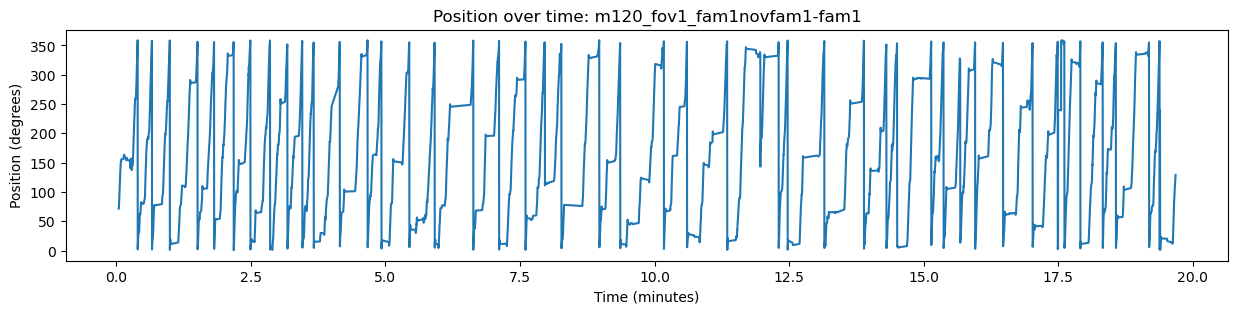

In [4]:
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(time/60, phi)
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Position (degrees)')
ax.set_title(f'Position over time: {animal}_{fov}_{experiment}-{run}')
plt.show()

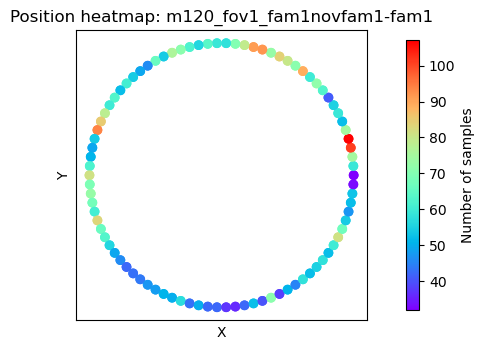

In [5]:
# Heat map of how well sampled is the position
n_points = 90
phi_mod = phi % 360
dphi = 360/n_points
bin_idx = np.floor(phi_mod / dphi).astype(int)
counts = np.zeros(n_points, dtype=int)
for i in range(len(phi_mod)):
    counts[bin_idx[i]] += 1
points_phi = (np.arange(n_points) * dphi) * np.pi / 180

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(np.cos(points_phi), np.sin(points_phi), c=counts, cmap='rainbow')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f'Position heatmap: {animal}_{fov}_{experiment}-{run}')
# add colorbar
cbar = plt.colorbar(ax.scatter(np.cos(points_phi), np.sin(points_phi), c=counts, cmap='rainbow'), pad=0.1, shrink=0.7)
cbar.set_label('Number of samples')
ax.set_aspect('equal')
plt.show()

# Spikes

NameError: name 'de' is not defined

In [15]:
points_phi 

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15